# Машинное обучение, ФКН ВШЭ

# Практическое задание 6

## Общая информация

Дата выдачи: 03.04.2017

Срок сдачи: 16.04.2017 23:59MSK

### О задании

Практическое задание 6 посвящено EM-алгоритму и его использовании в задачах классификации. В рамках данного задания вы:
 * научитесь моделировать данные, сгенерированные из распределений сложной природы;
 * реализуете ЕМ-алгоритм для 2 различных моделей генерации данных;
 * изучите поведение оценок параметров распределений и скрытых переменных в процессе ЕМ-алгоритма;
 * научитесь использовать ЕМ-алгоритм как метод обучения с учителем.
 
 
### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW6_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW6_IvanovII.ipynb*). Далее отправьте этот файл на hse.cs.ml+<номер группы>@gmail.com (например, hse.cs.ml+141@gmail.com для студентов группы БПМИ-141).

# EM-алгоритм

## Бинарная последовательность

Пусть наблюдается выборка бинарных значений $\mathbb{Y} = (y_1,\ldots, y_l), \; y_i\in\{0,1\}$. Все элементы выборки генерируются независимо, но известно, что в некоторый момент $z$ меняется частота генерации единиц, т.е.:
$$\mathbb{P}(y_i = 1) = 
\begin{cases}
\theta_1, \, i < z,\\
\theta_2, \, i \ge z. 
\end{cases}$$

В рамках данной части задания вам необходимо будет реализовать ЕМ-алгоритм для данной модели, где $z$–скрытая переменная, а $\theta_1, \theta_2$ – параметры распределения.

1\. **(1 балл)** Выведите формулы Е- и М-шагов алгоритма для заданной модели. Напомним, что результатом Е-шага является распределение скрытых переменных $q(z)$, М-шага — оценки на параметры распределения.

**E-шаг**.

$$
\alpha_k = \prod_{i = 1}^{k - 1} ([y_i = 1] \theta_1 + [y_i = 0] (1 - \theta_1)) * \prod_{i = k}^{n}([y_i = 1]\theta_2 + [y_i = 0] (1 - \theta_2))
$$

$$
z_k = \frac{\alpha_k}{\sum_{i}\alpha_k}
$$

**М-шаг**.

$$
\log{p(Y, Z | \theta)} = \sum_{i = 1}^{z - 1}([y_i = 1]\theta_1 + [y_i = 0] (1 - \theta_1)) + \sum_{i = z}^{n}([y_i = 1]\theta_2 + [y_i = 0] (1 - \theta_2)) = 
$$

$$
\log{\theta_1}\left(\sum_{k = 1}^{l + 1} z_k \sum_{i = 1}^{k - 1}[y_i = 1] \right) + \log{1 - \theta_1}\left(\sum_{k = 1}^{l + 1} z_k \sum_{i = 1}^{k - 1}[y_i = 0] \right) + \log{\theta_2}\left(\sum_{k = 1}^{l + 1} z_k \sum_{i = k}^{n}[y_i = 1] \right) + \log{(1 - \theta_2)}\left(\sum_{k = 1}^{l + 1} z_k \sum_{i = k}^{n}[y_i = 0] \right) \rightarrow \min
$$

$$
\alpha = \log{\theta_1}\left(\sum_{k = 1}^{l + 1} z_k \sum_{i = 1}^{k - 1}[y_i = 1] \right)
$$

$$
\beta = \log{1 - \theta_1}\left(\sum_{k - 1}^{l + 1} z_k \sum_{i = 1}^{k - 1}[y_i = 0] \right)
$$

$$
\frac{1}{\theta_1}\alpha = \frac{1}{1 - \theta_1} \beta
$$
$$
\alpha - \alpha \theta_1 = \theta_1\beta
$$
$$
\theta_1 = \frac{\alpha}{\beta}
$$

2\. **(2 балла)** Реализуйте ЕМ-алгоритм для заданной модели в виде функции, параметром которой является наблюдаемая выборка, а возвращаемым значением — векторы с оценками параметров распределений на каждой итерации алгоритма. В качестве критерия останова можете использовать ограничение количества итераций. Формат входных и выходных данных функции остаётся на ваше усмотрение.

In [128]:
import numpy
import matplotlib
import math

import matplotlib.pyplot as plt


def e_step(theta_1, theta_2, y):
    z0 = 1
    for y_el in y:
        if y_el == 0:
            z0 *= (1 - theta_2)
        else:
            z0 *= theta_2
    z = numpy.zeros(len(y) + 1)
    z[0] = z0
    for i in xrange(len(y)):
        if y[i] == 0:
            z0 *= (1 - theta_1) / (1 - theta_2)
        else:
            z0 *= theta_1 / theta_2
        z[i + 1] = z0
    z = numpy.array(z)
    z /= sum(z)
    return z

def m_step(z, y1, y2, y3, y4):
    theta_1 = numpy.dot(z, y1) / (numpy.dot(z, y1) + numpy.dot(z, y2))
    theta_2 = numpy.dot(z, y3) / (numpy.dot(z, y3) + numpy.dot(z, y4))

    return (theta_1, theta_2)

def precalculate_for_m(y):
    y1 = numpy.zeros(len(y) + 1)
    y2 = numpy.zeros(len(y) + 1)
    y3 = numpy.zeros(len(y) + 1)
    y4 = numpy.zeros(len(y) + 1)
    y1[0] = 0
    y2[0] = 0
    y3[len(y)] = 0
    y4[len(y)] = 0
    for i in xrange(len(y)):
        y1[i + 1] = y1[i] + (y[i] == 1)
        y2[i + 1] = y2[i] + (y[i] == 0)
        y3[len(y) - i - 1] = y3[len(y) - i] + (y[len(y) - i - 1] == 1)
        y4[len(y) - i - 1] = y4[len(y) - i] + (y[len(y) - i - 1] == 0)
    return (y1, y2, y3, y4)

def get_math_expectation(z, theta_1, theta_2, y1, y2, y3, y4):
    return (
        math.log(theta_1) * numpy.dot(z, y1)
        + math.log(1 - theta_1) * numpy.dot(z, y2)
        + math.log(theta_2) * numpy.dot(z, y3)
        + math.log(1 - theta_2) * numpy.dot(z, y4)
    )

def em_alg(y, initial_theta_1=0.5, initial_theta_2=0.5, iterations=100):
    (y1, y2, y3, y4) = precalculate_for_m(y)
    theta_1 = initial_theta_1
    theta_2 = initial_theta_2
    result = []
    for i in xrange(iterations):
        z = e_step(theta_1, theta_2, y)
        (theta_1, theta_2) = m_step(z, y1, y2, y3, y4)
        math_expectation = get_math_expectation(z, theta_1, theta_2, y1, y2, y3, y4)
        result.append((theta_1, theta_2, numpy.argmax(z) + 1, math_expectation))
    return result

def sample_values(theta_1, theta_2, z, l):
    y = numpy.zeros(l)
    for i in xrange(l):
        rand = numpy.random.rand()
        if i + 1 < z:
            y[i] = (rand < theta_1)
        else:
            y[i] = (rand < theta_2)
    return y


3\. **(0.5 балла)** Проведите эксперимент для $\theta_1 = 0.1$, $\theta_2 = 0.9, z=50, l=100.$ Для этого выполните следующие действия:
- сгенерируйте выборку для заданных истинных значений $\theta_1, \theta_2, z, l$;
- примените реализованную в п. 2 функцию;
- постройте графики зависимостей оценок $\theta_1, \theta_2, z$ от номера итерации ЕМ-алгоритма. 

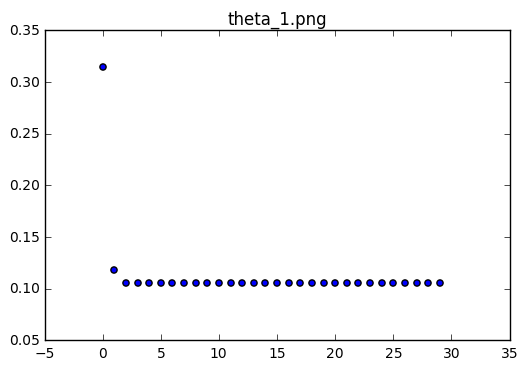

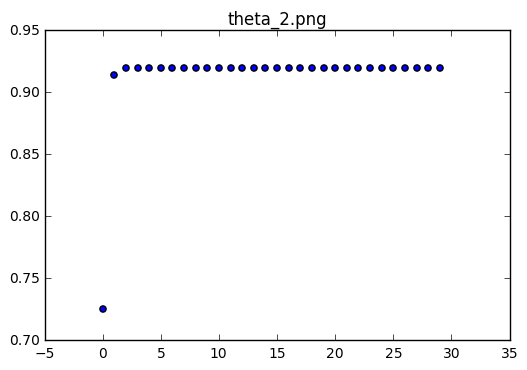

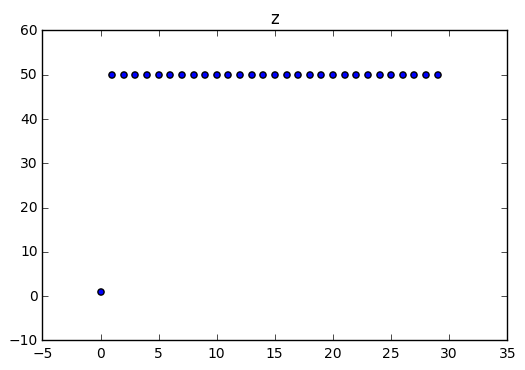

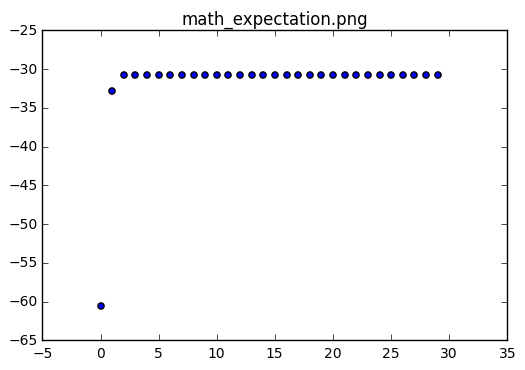

(0.10518387810744219, 0.92002063940585099, 50, -30.699950682296929)

In [129]:
def experiment_with_em(theta_1=0.1, theta_2=0.9, z=50, l=100, iterations=30, plot=False):
    y = sample_values(theta_1, theta_2, z, l)
    em_result = em_alg(y, iterations=iterations)
    if plot:
        for (name, ident) in (("theta_1.png", 0), ("theta_2.png", 1), ("z", 2), ("math_expectation.png", 3)):
            plt.scatter(range(iterations), [r[ident] for r in em_result])
            plt.title(name)
            plt.show()
    return em_result[-1]

numpy.random.seed(0)
experiment_with_em(plot=True)

4\. **(0.5 балла)** Какой функционал оптимизирует ЕМ-алгоритм? Постройте график зависимости этого функционала от номера итерации ЕМ-алгоритма. Ведёт ли эта величина себя монотонно?

**Ответ:** на последнем графике сверху видно что да, величина ведет себя монотонно

5\. **(0.5 балла)** Повторите эксперимент аналогично п.3 1000 раз для $\theta_1 = 0.49$, $\theta_2 = 0.51, z=500, l=550$. Оцените RMSE для между истинным значением и оценками, полученными в результате экспериментов, для $\theta_1, \theta_2, z$, а также постройте гистограмму полученных в результате экспериментов остатков для этих величин.

RMSE theta_1: 0.0367104322716


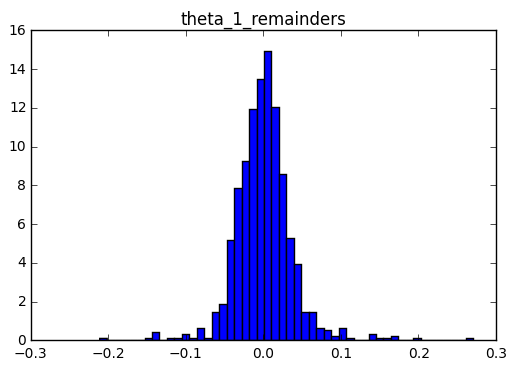

RMSE theta_2: 0.0405829431506


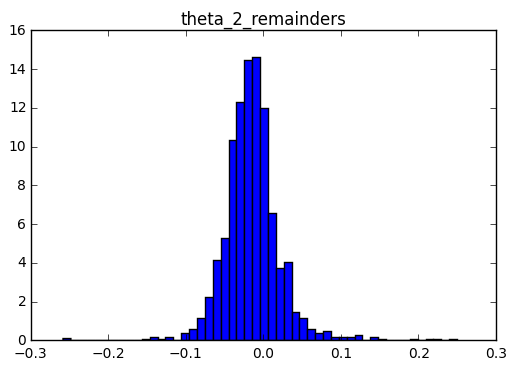

RMSE z: 257.446563387


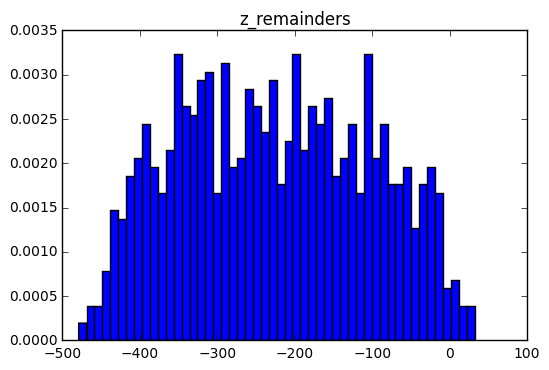

In [138]:
def many_em_experiments(theta_1=0.49, theta_2=0.51, z=500, l=550, iterations=100, experiments=1000):
    theta_1_array = numpy.zeros(experiments)
    theta_2_array = numpy.zeros(experiments)
    z_array = numpy.zeros(experiments)

    for i in xrange(experiments):
        (theta_1_array[i], theta_2_array[i], z_array[i], _) = experiment_with_em(theta_1=theta_1, theta_2=theta_2, z=z, l=l, iterations=iterations, plot=False)
        #print "{i}th exmeriment done".format(i=i)
        #print theta_1_array[i], theta_2_array[i], z_array[i]

    for (name, array, target) in (("theta_1", theta_1_array, theta_1), ("theta_2", theta_2_array, theta_2), ("z", z_array, z)):
        print "RMSE {name}: {value}".format(name=name, value=numpy.sqrt(((array - target) ** 2).mean()))
        plt.hist(array - target, 50, normed=1)
        plt.title("{name}_remainders".format(name=name))
        plt.show()

numpy.random.seed(0)
many_em_experiments()


## Смесь нормальных распределений

Пусть данные описываются смесью многомерных нормальных распределений:
$$p(x_i|\Theta) = \sum_{k=1}^K \pi_k p(x_i|\theta_k) = \sum_{k=1}^K \pi_k \mathcal{N}(x_i|\mu_k, \Sigma_k).$$

В рамках данной части задания вам необходимо реализовать ЕМ-алгоритм для нахождения параметров указанного распределения (формулы для данной модели были выведены в материалах [семинара 15](https://github.com/esokolov/ml-course-hse/blob/master/2016-spring/seminars/sem15-EM.pdf)) и применить его для решения задачи классификации на датасете MNIST. Чтобы применение ЕМ-алгоритма к датасету MNIST было осмысленным, мы воспользуемся методом понижения размерности t-SNE.

7\. **(2 балла)** Реализуйте ЕМ-алгоритм для заданной модели в виде функции, параметром которой является наблюдаемая выборка, а возвращаемым значением — итоговые оценки параметров распределения и значения скрытых переменных. В качестве критерия останова можете использовать ограничение количества итераций. Формат входных и выходных данных функции остаётся на ваше усмотрение.

In [145]:
def em(data, k=10, iterations=2):
    n_data = data.shape[0]
    features_n = data.shape[1]

    pi = np.ones((k,))
    g = np.empty((n_data, k))
    sigma = [np.diag(np.ones((features_n,))) for i in range(k)]
    mu = np.ones((k, features_n))

    for i in range(iterations):
        # E - step
        for i in range(n_data):
            s = 0
            for j in range(k):
                s += pi[j] * scipy.stats.multivariate_normal.pdf(data[i], mu[j], sigma[j])

            for j in range(k):
                g[i][j] = pi[j] * scipy.stats.multivariate_normal.pdf(data[i], mu[j], sigma[j])

        # M - step

        new_pi = np.zeros((k,))
        new_sigma = [np.diag(np.ones((features_n,))) for i in range(k)]
        new_mu = np.ones((k, features_n))

        for i in range(k):
            for j in range(n_data):
                new_pi[i] += np.sum(g[j][i])
                new_mu[i] += g[j][i] * data[j]
                new_sigma += g[j][i] * (data[j] - new_mu[i]).dot(data[j] - new_mu[i])

            new_mu[i] /= n_data * pi[i]
            new_sigma[i] /= n_data * pi[i]

        new_pi /= n_data

        pi = new_pi
        mu = new_mu
        sigma = new_sigma


    return pi, mu, sigma

8\. **(1 балл)** Загрузите признаковые описания и значения целевой переменной для 2000 случайных объектов из обучающей выборки датасета [MNIST](http://yann.lecun.com/exdb/mnist/) и сохраните их в соответствующие переменные.

In [95]:
import os
import struct
import numpy as np

with open("train-labels-idx1-ubyte", 'rb') as flbl:
    magic, num = struct.unpack(">II", flbl.read(8))
    lbl = np.fromfile(flbl, dtype=np.int8)

with open("train-images-idx3-ubyte", 'rb') as fimg:
    magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

get_img = lambda idx: (lbl[idx], img[idx])


In [96]:
from sklearn.utils import shuffle
X, y = shuffle(img,lbl, random_state=42)

X = X[:2000]
y = y[:2000]

In [97]:
X = [x.reshape(28*28) for x in X]

In [55]:
y.shape

(2000,)

9\. **(0.5 балла)** Визуализируйте полученную выборку на плоскости при помощи t-SNE, используя различные цвета для объектов различных классов.

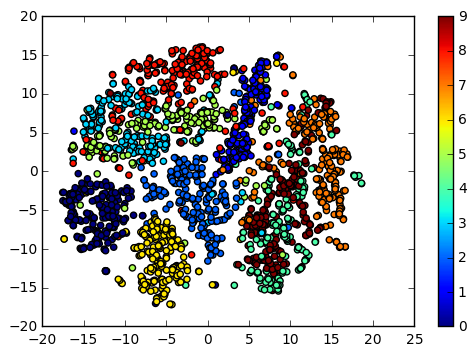

In [68]:
tsne = manifold.TSNE(n_components=2, init='random', random_state=0)
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y)
plt.colorbar(ticks=range(10))
plt.show()

10\. **(0.5 балла)** Для выборки из п. 8 понизьте количество признаков до 3 при помощи t-SNE и примените функцию из п. 7 для разделения выборки на $K=10$ компонент.

In [98]:
tsne = manifold.TSNE(n_components=3, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X)

In [88]:
print(data)

[  4.   6.   6. ...,   4.  11.   3.]


In [117]:
X_tsne

array([[-120.70952714, -543.34981596,  420.22098333],
       [ 406.49219151,  831.33487786,  562.27768209],
       [ -16.08433622,  336.89266453, -497.76700131],
       ..., 
       [ 181.12158671,  241.22665359,  575.77402093],
       [-276.76362267, -418.90533585,  484.51826675],
       [  34.39182545,  -99.49129731, -614.98493862]])

In [147]:
pi, mu, sigma = em(X_tsne, iterations=2)

/root/anaconda3/envs/mxnet2/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in divide
/root/anaconda3/envs/mxnet2/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: divide by zero encountered in divide
/root/anaconda3/envs/mxnet2/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in divide


Полученное разделение выборки на компоненты можно использовать для построения классификатора, предсказывающего изображенную цифру. Для этого будем считать прогнозом для всех объектов $k$-ой компоненты самую частую истинную метку среди объектов этой компоненты:

$$a(x_i) = \arg \max_{k \in \{1, \dots, 10\}} \sum_{j=1}^l [z_j = z_i] [y_j = k],$$

где $z_i$ — вектор скрытых переменных для объекта выборки $x_i$.

11\. **(0.5 балла)** Выведите значение accuracy на используемой выборке для описанного выше способа построения прогнозов на объектах и истинной разметки выборки.

In [ ]:
# Your code here

12\. **(1 балл)** Постройте график зависимости значения accuracy на используемой выборке для описанного выше способа построения прогнозов на объектах и истинной разметки выборки от числа компонент $K$, фигурирующего в ЕМ-алгоритме.

In [ ]:
# Your code here